# Import neccessary packages and Define Helper Packages
- For this demonstration, we need to install [albumentations](https://albumentations.ai/) for image augmentation
- import neccessary packages, most especially HuggingFace, some image handling packages, and Pytorch

In [1]:
! pip install albumentations


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import os, numpy as np, pandas as pd
from transformers import pipeline, AutoProcessor, AutoModelForZeroShotImageClassification
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn.functional as F
import pytorch_lightning as pl

import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from skimage import io

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

2023-04-19 18:47:43.820643: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 18:47:44.493639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
def plot_image_grid(images, ncols=None, cmap='gray'):
    '''Plot a grid of images'''
    if not ncols:
        factors = [i for i in range(1, len(images)+1) if len(images) % i == 0]
        ncols = factors[len(factors) // 2] if len(factors) else len(images) // 4 + 1
    nrows = int(len(images) / ncols) + int(len(images) % ncols)
    imgs = [images[i] if len(images) > i else None for i in range(nrows * ncols)]
    f, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
    axes = axes.flatten()[:len(imgs)]
    
    for img, ax in zip(imgs, axes.flatten()): 
        if np.any(img):
            if len(img.shape) > 2 and img.shape[2] == 1:
                img = img.squeeze()
            ax.imshow(img, cmap=cmap)

# Connect to the Data Set
Set the parameters for connecting to a data set and look at some example images. 

In [6]:
# specify the data directory

data_dir = "all_images"

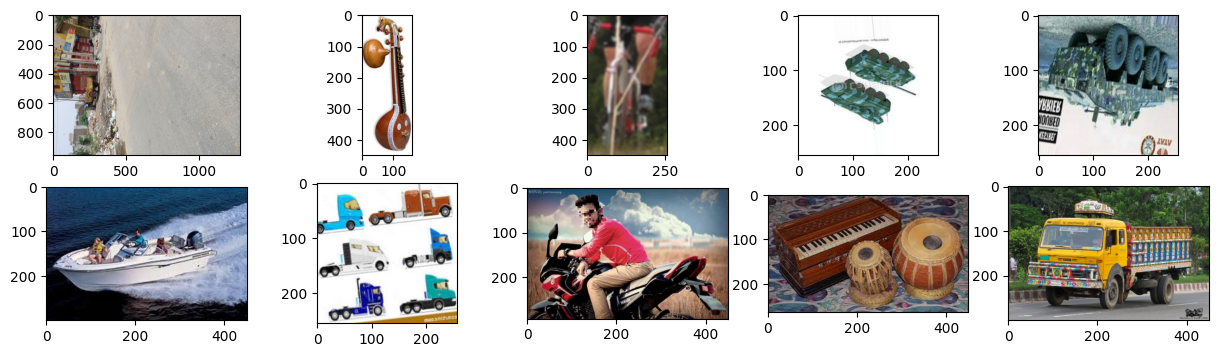

In [5]:
# visualize some example images

img_examples = [os.path.join(data_dir,i) for i in np.random.choice(os.listdir(data_dir), size=10)]

plot_image_grid([mpimg.imread(i) for i in img_examples])

In [7]:
# NOTE: I am using this to get labels for the images. In the real-world, one does not have this information

mil_file_names = ['Armored personnel carriers', 'light utility vehicles', 'Anti-aircraft', 'war_tank', 'artillery', 'tanks', 'Prime movers', 'soldier']

# Zero-shot Image Labeling
For the zero-shot image labeling, we will be using HuggingFace's [Zero-Shot Image Classification](https://huggingface.co/docs/transformers/tasks/zero_shot_image_classification#zeroshot-image-classification-by-hand) ability. This is the simplest way to get an image classification going. To do this we will:
- specify a model and create a pipeline with that model
- read in the image files
- decide on what labels we want to find in our images
- check the results

In [8]:
# Create the Zero-shot model

checkpoint = "openai/clip-vit-large-patch14"

classifier = pipeline(model=checkpoint, task="zero-shot-image-classification", device=0)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [11]:
# Read in some image files
img_files = [os.path.join(data_dir,i) for i in np.random.choice(os.listdir(data_dir), size=1000)]
img_labels = np.max([[1 if i in filename else 0 for i in mil_file_names] for filename in img_files], axis=1)

# specify what we want to find in the images
candidate_labels = ["military", "non-military"]

# specify a threshold (between 0 and 1) for wether we want to count an image for our "military" class
threshold= 0.5

In [12]:
# zero-shot classify the images into our given labels

results = classifier(img_files, candidate_labels=candidate_labels)

In [19]:
# take a look at the results we get back from the pipeline

results[0:5]

[[{'score': 0.9604912400245667, 'label': 'military'},
  {'score': 0.03950871154665947, 'label': 'non-military'}],
 [{'score': 0.5514742136001587, 'label': 'military'},
  {'score': 0.4485258162021637, 'label': 'non-military'}],
 [{'score': 0.8588670492172241, 'label': 'military'},
  {'score': 0.1411329209804535, 'label': 'non-military'}],
 [{'score': 0.7813408970832825, 'label': 'military'},
  {'score': 0.21865911781787872, 'label': 'non-military'}],
 [{'score': 0.8615265488624573, 'label': 'non-military'},
  {'score': 0.1384735256433487, 'label': 'military'}]]

In [14]:
# Get those files we flagged as of interest (e.g. pictures of military things)

mil_results = np.array([[i['score'] for i in res if i['label'] == "military"] for res in results]).flatten()
mil_results_files = [img_files[i] for i in np.where(mil_results > threshold)[0]]

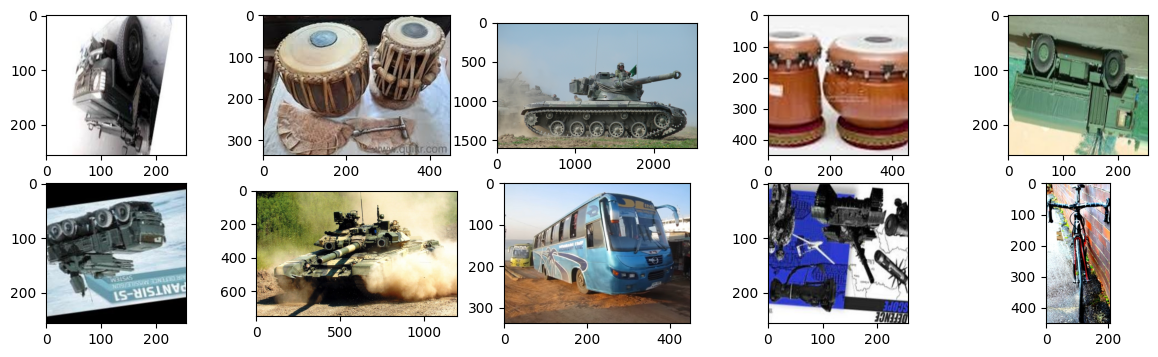

In [15]:
plot_image_grid([mpimg.imread(i) for i in mil_results_files][:10])

In [16]:
roc_auc_score(img_labels, mil_results)

0.9081609312873821

In [17]:
print(classification_report(img_labels, mil_results >threshold))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85       711
           1       0.61      0.90      0.73       289

    accuracy                           0.81      1000
   macro avg       0.78      0.83      0.79      1000
weighted avg       0.85      0.81      0.82      1000



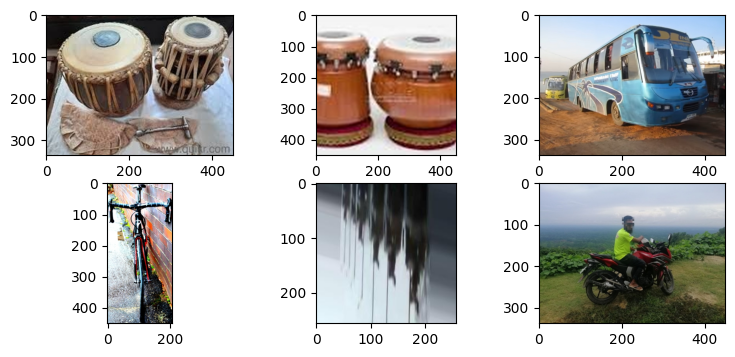

In [18]:
# Get the files of the images that were not classified correctly

wrong_results = [img_files[i] for i in np.where( (img_labels - np.where(mil_results > threshold, 1,0)) !=0)[0]]
plot_image_grid([mpimg.imread(i) for i in wrong_results][:6])

# Prompt Engineering for Better Performance
Now, having established a quick way to use a zero-shot model to find the images we want, we are now going to engage in [prompt engineering](https://heartbeat.comet.ml/prompt-engineering-ddbbd39d61bb) in order to get better performance form the model. While this is an active area of research, there are a couple of know ways to do prompt engineering with these image-text contrastive models in an unsupervised way:
- using more specific prompts (e.g. `["military vehicle", "soldier", "truck", "car", "boat", "motorcycle", "bus"]`)
- providing context (e.g. `["picture of a military vehicle","picture of a soldier", "picture of a truck", "picture of a car", "picture of a boat", 
"picture of a motorcycle", "sketch of a military vehicle"]`). As a side note, this idea was one of the ones recommend by [CLIPs](https://arxiv.org/abs/2103.00020) original authors.
- Adding in 'distractor' prompts as has been done with the `"motorcycle", "bus"` etc. labels. __Note__: this idea has not been fully tested but rather it is something we have noticed in practice

In [24]:
# Read in some image files
img_files = [os.path.join(data_dir,i) for i in np.random.choice(os.listdir(data_dir), size=1000)]
img_labels = np.max([[1 if i in filename else 0 for i in mil_file_names] for filename in img_files], axis=1)

# specify what we want to find in the images
candidate_labels = ["military vehicle", "soldier", "truck", "car", "boat", "motorcycle", "bus"]

# specify a threshold (between 0 and 1) for wether we want to count an image for our "military" class
threshold= 0.5

In [25]:
# zero-shot classify the images into our given labels

results = classifier(img_files, candidate_labels=candidate_labels)

In [26]:
# Get those files we flagged as of interest (e.g. pictures of military things)

mil_results = np.array([[i['score'] for i in res if i['label'] in ["military vehicle", "soldier"]] for res in results])
mil_results_files = [img_files[i] for i in np.where(np.max(mil_results, axis=1) >threshold)[0]]

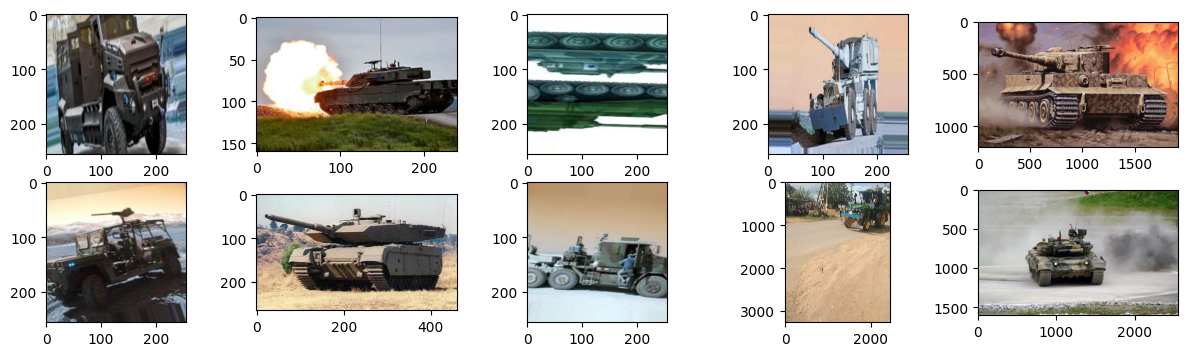

In [27]:
plot_image_grid([mpimg.imread(i) for i in mil_results_files][:10])

In [28]:
roc_auc_score(img_labels, np.max(mil_results, axis=1))

0.9475171670684491

In [29]:
print(classification_report(img_labels, np.max(mil_results, axis=1) >threshold))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       676
           1       0.84      0.81      0.82       324

    accuracy                           0.89      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.89      0.89      0.89      1000



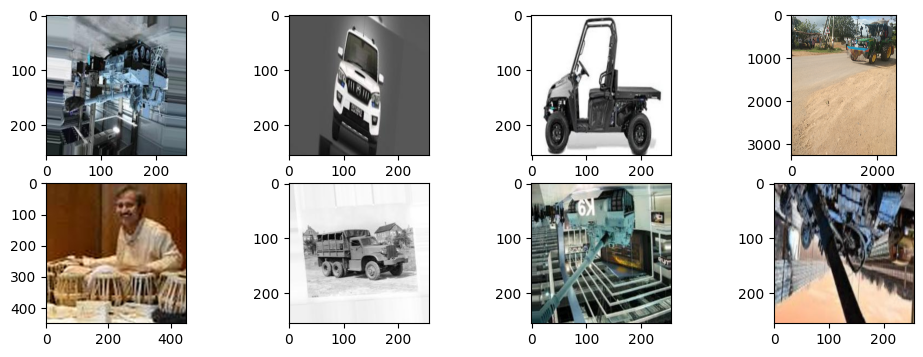

In [30]:
# Get the files of the images that were not classified correctly

wrong_results = [img_files[i] for i in np.where( (img_labels - np.where(np.max(mil_results, axis=1) > threshold, 1,0)) !=0)[0]]
plot_image_grid([mpimg.imread(i) for i in wrong_results][:8])

# Fine Tuning the Model
Finally, we can also __fine tune__ a zero shot model for increased performance for a specific task domain. In this case, since we are using an image-text contrastive model, we need to provide pairs of images and their associated text (i.e. captions) for the model to learn a joint representation of the text and images. Furthermore, we will also be following the advice in [LiT](https://arxiv.org/abs/2111.07991) and only training the project layers and not the image and text encoders. For this, we will be using PyTorch Lightning as base PyTorch data handlers as the means by which we can finetune the HuggingFace model. Thus it should be noted that there are other ways of doing this. Some other examples of training CLIP are available [here](https://sachinruk.github.io/blog/pytorch/pytorch%20lightning/loss%20function/gpu/2021/03/07/CLIP.html), [here](https://colab.research.google.com/github/arampacha/CLIP-rsicd/blob/master/nbs/Finetuning_CLIP_with_HF_and_jax.ipynb), and [here](https://github.com/clip-italian/clip-italian/blob/master/hybrid_clip/run_hybrid_clip.py).

#### Note about Prompt Engineering and Fine tuning

From the previous section, it should be clear that "prompt engineering" presents some distinct advantages when it comes to using zero-shot TVMs. While this still is an active area of research, there are some new and pretty useful methods out there for more sophisticated prompt engineering. Some supervised examples include [CoCoOp](https://openaccess.thecvf.com/content/CVPR2022/html/Zhou_Conditional_Prompt_Learning_for_Vision-Language_Models_CVPR_2022_paper.html), [KgCoOp](https://arxiv.org/abs/2303.13283), [Compositional Soft Prompting](https://arxiv.org/abs/2204.03574), [Learning to name Classes](https://arxiv.org/abs/2304.01830), [R-tuning](https://arxiv.org/abs/2303.051220). These techniques can actually be used in place of fine tuning and can even perform better than some forms of fine tuning (e.g., linear probing)

In [31]:
# set up the zero-shot model, its processor and the device we will be training on

model = AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-large-patch14")
processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [44]:
# create a dataset class to handle the data processing, using HuggingFace's CLIP processor, and a collate function

class CaptionedImagesDataset(Dataset):
    """
    A PyTorch Dataset for loading images with their associated captions.

    Args:
        dataframe (pandas.DataFrame): A dataframe containing the image paths and captions.
        root_dir (str): The root directory where the images are stored.
        processor (transformers.Processor): A CLIP text-vision processor for encoding the captions and images.
        transform (optional, callable): A callable transform to be applied to the images.
    """
    def __init__(self, dataframe, root_dir, processor, transform=None):
        self.annotations = dataframe
        self.root_dir = root_dir
        self.processor = processor
        self.transform = transform
        
    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.annotations)
    
    def __getitem__(self, index):
        """
        Loads the image and caption at the given index.

        Args:
            index (int): The index of the sample to load.

        Returns:
            dict: A dictionary containing the encoded caption and image pixel values.
        """
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        text = self.annotations.iloc[index, 1]
        image = io.imread(img_path)
        if image.ndim <3:
            image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
        if self.transform is not None:
            # uncomment for use with albumentations transforms
            augmentations = self.transform(image=image)
            image = augmentations["image"]

        inputs = processor( text=text, images=image, return_tensors="pt", padding=True)
        
        return inputs
    
def collate_fn(batch):
    """
    Collates a batch of samples into a single batch for training a CLIP text-vision model.

    Args:
        batch (list): A list of samples, where each sample is a dictionary containing the encoded caption and image pixel values.

    Returns:
        dict: A dictionary containing the collated batch of encoded captions and image pixel values.
    """
    collated_batch = {
        k: [d.get(k) for d in batch]
        for k in set().union(*batch)
    }
    
    max_len = max([i.shape[1] for i in collated_batch['input_ids']])
    collated_batch['input_ids'] = torch.stack([F.pad(i, (0, max_len-i.shape[1]), mode='constant', value=i[0][-1]) if i.shape[1] <max_len else i for i in collated_batch['input_ids']]).squeeze()
    collated_batch['pixel_values'] = torch.stack(collated_batch['pixel_values']).squeeze()
    collated_batch['attention_mask'] = torch.stack([F.pad(i, (0, max_len-i.shape[1]), mode='constant', value=0) if i.shape[1] <max_len else i for i in collated_batch['attention_mask']]).squeeze()
    
    return collated_batch

In [45]:
# Use albumentations for image augmentation

train_transforms = A.Compose([
    A.Resize(model.config.vision_config.image_size, model.config.vision_config.image_size),
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.4, var_limit=(0.0, 20)),
    A.ShiftScaleRotate(always_apply=False, p=0.3, shift_limit=(-0.1, 0.1), 
                       scale_limit=(-0.2, 0.2), rotate_limit=(-15, 15),
                       border_mode=0, value=(0, 0, 0)),
    A.OneOf([
        A.RandomBrightnessContrast(p=0.4, brightness_limit=(-0.1, 0.3), 
                                 contrast_limit=(-0.2, 0.2), brightness_by_max=True),
        A.HueSaturationValue(hue_shift_limit=12, sat_shift_limit=12, val_shift_limit=5, p=0.4),
        A.CLAHE(always_apply=False, p=0.4, clip_limit=(1, 10), tile_grid_size=(4, 12)),
        A.ColorJitter(p=0.4)
    ]),
    A.Cutout(always_apply=False, p=0.3, num_holes=5, max_h_size=15, max_w_size=15),
    ToTensorV2()
    ])

valid_transforms = A.Compose([
    A.Resize(model.config.vision_config.image_size, model.config.vision_config.image_size),
    ToTensorV2()
    ])

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [46]:
# Read in our captioned data

captions_df = pd.read_csv("all_images_captions.csv", header=None)
train_df, val_df = train_test_split(captions_df, test_size= 0.2)

In [47]:
# Create our PyTorch data handling objects for training the model

train = CaptionedImagesDataset(train_df, root_dir="all_images", processor=processor, transform = train_transforms)
validation = CaptionedImagesDataset(val_df, root_dir="all_images", processor=processor, transform = valid_transforms)
train_loader = DataLoader(dataset=train, batch_size=12, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(dataset=validation, batch_size=24, shuffle=False, collate_fn=collate_fn)

In [50]:
# Create a Pytorch Lightning Module to handle training. Note that one has to place the data tensors on the training device manually, which you normally do not have to 
# do with Lightning normally

class LightningModel(pl.LightningModule):
    """
    Pytorch Lightning Module for fine-tuning the CLIP text-vision model.

    Args:
    model (CLIP): The pre-trained CLIP model to be fine-tuned.
    lr (float): Learning rate to use for training. Defaults to 3e-5.

    Returns:
    None
    """
    def __init__(self, model, lr: float = 3e-5) -> None:
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        """
        Runs a single training step on a batch of data.

        Args:
        batch (dict): A dictionary of tensors containing the inputs and labels for the current training batch.
        batch_idx (int): The index of the current batch.

        Returns:
        float: The training loss for the current batch.
        """
        outputs = self.model(
            input_ids=batch['input_ids'].to('cuda'),
            attention_mask=batch['attention_mask'].to('cuda'),
            pixel_values=batch['pixel_values'].to('cuda'),
            return_loss=True,
        )    
        self.log("training_loss", outputs.loss, on_step=True)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        """
        Runs a single validation step on a batch of data.

        Args:
        batch (dict): A dictionary of tensors containing the inputs and labels for the current validation batch.
        batch_idx (int): The index of the current batch.

        Returns:
        float: The validation loss for the current batch.
        """
        outputs = self.model(
            input_ids=batch['input_ids'].to('cuda'),
            attention_mask=batch['attention_mask'].to('cuda'),
            pixel_values=batch['pixel_values'].to('cuda'),
            return_loss=True,
        )      
        self.log("training_loss", outputs.loss, on_step=True)
        return outputs.loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """
        Configures the optimizer to be used during training.

        Args:
        None

        Returns:
        torch.optim.Optimizer: The optimizer to be used during training.
        """
        vision_params = {"params": self.model.visual_projection.parameters(), "lr": self.lr}
        caption_params = {"params": self.model.text_projection.parameters() , "lr": self.lr}
        return torch.optim.Adam([vision_params, caption_params])

In [51]:
# Freeze the image and text encoders

for param in model.vision_model.parameters():
    param.requires_grad = False
    
for param in model.text_model.parameters():
    param.requires_grad = False

# Specify our training module

training_model = LightningModel(model)
trainer = pl.Trainer(
    max_epochs= 3,
    gradient_clip_val=1.0
)

# and, finally, finetune the model!!

trainer.fit(training_model, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | CLIPModel | 427 M 
------------------------------------
1.4 M     Trainable params
426 M     Non-trainable params
427 M     Total params
1,710.466 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 255 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [52]:
# Save our our trained model and its processor

model.save_pretrained("mil_objects_model")
processor.save_pretrained("mil_objects_model")

# Use a Fine tuned Model
Now, having trained a model to be better for our specific task, we can use that model in the same pipeline set up as before

In [54]:
trained_model = AutoModelForZeroShotImageClassification.from_pretrained("mil_objects_model")
processor = AutoProcessor.from_pretrained("mil_objects_model")
classifier = pipeline(model=trained_model, tokenizer=processor, image_processor=processor, task="zero-shot-image-classification", device=0)

In [57]:
img_files = [os.path.join(data_dir,i) for i in np.random.choice(os.listdir(data_dir), size=1000)]
img_labels = np.max([[1 if i in filename else 0 for i in mil_file_names] for filename in img_files], axis=1)

candidate_labels = ["military vehicle", "soldier", "truck", "car", "boat", "motorcycle", "bus"]

threshold= 0.5

In [58]:
results = classifier(img_files, candidate_labels=candidate_labels)

In [59]:
mil_results = np.array([[i['score'] for i in res if i['label'] in ["military vehicle", "soldier"]] for res in results])
mil_results_files = [img_files[i] for i in np.where(np.max(mil_results, axis=1) >threshold)[0]]

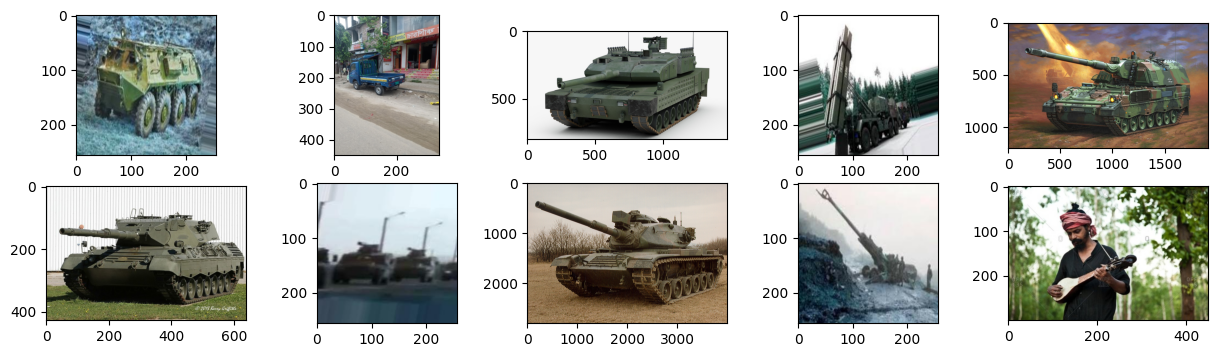

In [60]:
plot_image_grid([mpimg.imread(i) for i in mil_results_files][:10])

In [61]:
roc_auc_score(img_labels, np.max(mil_results, axis=1))

0.9715686981608367

In [62]:
print(classification_report(img_labels, np.max(mil_results, axis=1) >threshold))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       705
           1       0.85      0.90      0.88       295

    accuracy                           0.93      1000
   macro avg       0.91      0.92      0.91      1000
weighted avg       0.93      0.93      0.93      1000



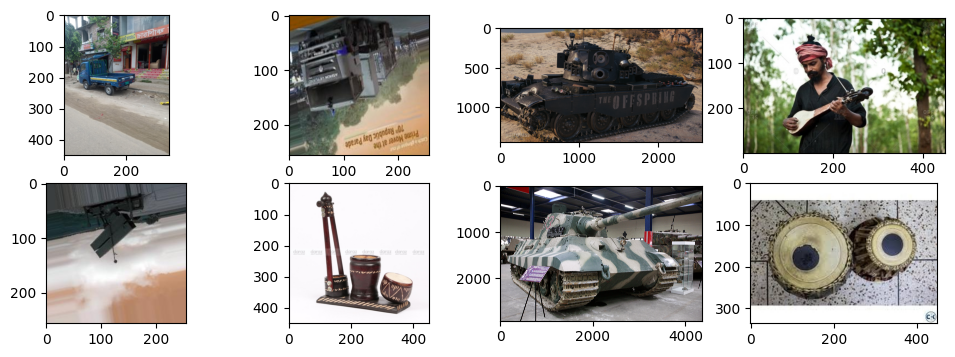

In [63]:
wrong_results = [img_files[i] for i in np.where( (img_labels - np.where(np.max(mil_results, axis=1) > threshold, 1,0)) !=0)[0]]
plot_image_grid([mpimg.imread(i) for i in wrong_results][:8])